<a href="https://colab.research.google.com/github/sexymonster/Projects/blob/main/TeamProject/TomatoDataCustom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.인트로

## 1-1. 패키지 로드

In [1]:
from google.colab import drive
import glob,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# 버전 오류를 잡아주는 코드
!pip install -U pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 268 kB 36.5 MB/s 
     |████████████████████████████████| 4.7 MB 54.4 MB/s 
     |████████████████████████████████| 9.8 MB 60.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 102 kB 68.0 MB/s 
     |████████████████████████████████| 690 kB 67.6 MB/s 
     |████████████████████████████████| 296 kB 74.8 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=124f2c8b6bd2d25603607fe70ab185f731e45b8f48d765cd3cb2383420122d93
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
Successfully built htmlmin
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: requests
  

## 1-2. 데이터 로드

In [3]:
path = "/content/gdrive/MyDrive/tomato/"

In [4]:
file_list = os.listdir(path)
print(file_list)

['2020_0010076_01', '2021_0010056_03', '2019_0010057_01', '2021_0010056_01', '2020_0020738_01', '2021_0010056_02', '2020_0010070_01', '2020_0010057_01', '2019_0010071_01', '2021_0010070_01', '2021_0020738_01', '2021_0010071_01', '2021_0010076_01', '2021_0010071_02', '2021_0020760_01']


## 1-3. 데이터 형태 수정

In [5]:
# 농가 번호를 입력하면 그 농가의 생육 정보(live), 제어 정보(ctrl), 환경 정보(env)들을 출력해주는 함수
def dataset(file, path=path):
  try:
    live = pd.read_excel(path + file+ "/방울토마토_생육정보_일별.xlsx")
    live = live.rename(columns = live.iloc[0])
    live = live.drop(live.index[0])
  except:
    pass

  ctrl = pd.read_excel(path + file+ "/방울토마토_제어정보_일별.xlsx")
  ctrl = ctrl.rename(columns = ctrl.iloc[0])
  ctrl = ctrl.drop(ctrl.index[0])

  env = pd.read_excel(path + file+ "/방울토마토_환경정보_일별.xlsx")
  env = env.rename(columns = env.iloc[0])
  env = env.drop(env.index[0])
  env = env.drop(env.columns[[3,5,6,9,10,11,13,14,19]], axis = 1)

  try:
    return live, ctrl, env
  except:
    return ctrl,env

In [6]:
# 모든 농가 데이터에 각각 번호(예를들면 ctrl1, ctrl2처럼)를 붙여줘서 출력해줌
file_list = os.listdir(path)

i = 1
live_list = []
ctrl_list = []
env_list= []

for file in file_list:
  try:
    globals()["live"+str(i)], globals()["ctrl"+str(i)], globals()["env"+str(i)]  = dataset(file,path)
    # live_list.append(globals()["live"+str(i)])
    # ctrl_list.append(globals()["ctrl"+str(i)])
    # env_list.append(globals()["env"+str(i)])
  except:
    globals()["ctrl"+str(i)], globals()["env"+str(i)]  = dataset(file,path)
    # ctrl_list.append(globals()["ctrl"+str(i)])
    # env_list.append(globals()["env"+str(i)])
  i += 1
print(i-1, '개의 농장 데이터가 있습니다.')

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


15 개의 농장 데이터가 있습니다.


# 2. 전처리

## 2-1. 데이터 전처리 함수

adapt(df) : 필요한 컬럼들로만 이루어진 데이터 프레임 생성\
astype(df) : 데이터들의 타입 변경 

In [7]:
# 유효한 컬럼을 알려주는 함수
def effcolm(df):
  effective = []
  columns = list(df)

  # 유효한 컬럼 추출 (nan값 개수가 1/3 이하인 컬럼)
  for col in columns:
    num_nan = df[col].isnull().sum()

    if num_nan < len(df[col])/3:
      effective.append(col)
  
  # 전부 0으로 표기된 의미 없는 컬럼도 제거(Nan,0.0이 같이 있으면 2개로 표시됨)
  for col in effective:
    if len(df[col].unique()) < 3:
      effective.remove(col) 


  return effective
  

In [8]:
# 유효한 컬럼으로만 이루어진 데이터프레임 생성
def adapt(df):
  eff_col = effcolm(df)
  df = df[eff_col]
  
  return df

## astype에서 Date를 인덱스로 설정하는 부분은 임의로 주석처리함

In [9]:
# dtype변경 함수

def astype(df):
  # 수집일, 조사일의 데이터 형태를 datetime으로 변경하고, 인덱스로 설정
  df['Date'] = pd.to_datetime(df.iloc[:,0])
  df = df.set_index(keys="Date", drop = True)
  df = df.drop(df.columns[0], axis=1)

  # 나머지 데이터들의 형태를 float으로 변경
  df = df.astype("float")

  return df

In [10]:
# 생육 데이터 자료의 변화량을 구해주는 함수
def delta(live):
  live_new = live[["주차","최종화방번호(번)"]]
  live_new["생장길이변화(dcm)"] = live.sort_values("Date")["생장길이(cm)"].pct_change()
  live_new["생장길이변화(dcm)"] = live.sort_values("Date")["화방높이(cm)"].pct_change()
  live_new["줄기굵기변화(dmm)"] = live.sort_values("Date")["줄기굵기(mm)"].pct_change()
  live_new["엽장변화(dcm)"] = live.sort_values("Date")["엽장(cm)"].pct_change()
  live_new["엽폭변화(dcm)"] = live.sort_values("Date")["엽폭(cm)"].pct_change()
  live_new["엽수변화(개)"] = live.sort_values("Date")["엽수(개)"].pct_change()
  live_new["개화군변화(점)"] = live.sort_values("Date")["개화군(점)"].pct_change()
  live_new["착과군변화(점)"] = live.sort_values("Date")["착과군(점)"].pct_change()
  live_new["열매수변화(개)"] = live.sort_values("Date")["열매수(개)"].pct_change()

  return live_new

In [11]:
def changedata(df):
  df = adapt(df)
  df = astype(df)
  
  return df

## 2-2. 데이터 처리 과정

### 2-2-1. 환경데이터

In [94]:
env2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 1 to 169
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   수집일           169 non-null    object
 1   내부CO2(ppm)    169 non-null    object
 2   이슬점온도(도)      0 non-null      object
 3   토양EC(dS/m)    0 non-null      object
 4   내부습도(%)       169 non-null    object
 5   지습(%)         131 non-null    object
 6   강우감지          168 non-null    object
 7   일사량(W/m-2·s)  169 non-null    object
 8   외부온도(도)       169 non-null    object
 9   내부온도(도)       169 non-null    object
 10  지온(도)         131 non-null    object
 11  외부풍속(m/s)     168 non-null    object
dtypes: object(12)
memory usage: 17.2+ KB


In [ ]:
env2 = adapt(env2)

In [ ]:
env2 = astype(env2)

In [ ]:
env2

,내부CO2(ppm),내부습도(%),강우감지,일사량(W/m-2·s),외부온도(도),내부온도(도),지온(도),외부풍속(m/s)
Date,,,,,,,,
2021-01-12,635.18,81.00,0.34,110.15,-3.13,14.74,NaN,0.20
2021-01-13,552.26,84.38,0.00,63.94,1.82,17.46,NaN,0.05
2021-01-14,532.32,82.04,0.00,173.33,1.74,17.91,NaN,0.35
2021-01-15,455.24,87.31,0.00,82.31,8.69,17.30,NaN,1.84
2021-01-16,530.14,83.20,0.00,129.99,-0.93,17.63,NaN,0.93
...,...,...,...,...,...,...,...,...
2021-06-26,423.34,78.29,0.37,272.93,22.80,25.62,25.34,0.70
2021-06-27,385.63,76.08,0.00,355.98,24.16,26.05,26.15,0.56
2021-06-28,381.62,81.28,0.00,224.24,24.12,25.68,26.65,0.51


In [ ]:
env2.index.to_list

<bound method IndexOpsMixin.tolist of DatetimeIndex(['2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15',
               '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19',
               '2021-01-20', '2021-01-21',
               ...
               '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
               '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
               '2021-06-29', '2021-06-30'],
              dtype='datetime64[ns]', name='Date', length=169, freq=None)>

In [ ]:
# for i in range(len(new_live2)):
#   dlist = new_live2.index.to_list

#   for x in range(dlist[i],dlist[i+1]):
#       start = x
#       temp = new_live2[(new_live2["height"] >= start) & (new_live2["height"] < end)]
#       print("{}이상 {}미만 : {}".format(start, end, temp["height"].mean()))


### 2-2-2. 생육데이터

In [ ]:
live2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 1 to 24
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   조사일        24 non-null     object
 1   주차         24 non-null     object
 2   생장길이(cm)   24 non-null     object
 3   화방높이(cm)   24 non-null     object
 4   줄기굵기(mm)   24 non-null     object
 5   엽장(cm)     24 non-null     object
 6   엽폭(cm)     24 non-null     object
 7   엽수(개)      24 non-null     object
 8   개화군(점)     24 non-null     object
 9   착과군(점)     24 non-null     object
 10  열매수(개)     24 non-null     object
 11  최종화방번호(번)  24 non-null     object
dtypes: object(12)
memory usage: 2.4+ KB


In [ ]:
live2 = adapt(live2)

In [ ]:
live2 = astype(live2)

In [ ]:
new_live2 = delta(live2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [ ]:
new_live2

,주차,최종화방번호(번),생장길이변화(dcm),줄기굵기변화(dmm),엽장변화(dcm),엽폭변화(dcm),엽수변화(개),개화군변화(점),착과군변화(점),열매수변화(개)
Date,,,,,,,,,,
2021-01-20,2.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-27,3.0,0.00,NaN,0.324561,0.527903,0.546392,0.700000,NaN,NaN,NaN
2021-02-03,4.0,0.00,NaN,-0.165563,0.444225,0.375000,0.000000,NaN,NaN,NaN
2021-02-09,5.0,0.00,NaN,-0.051587,0.000000,0.167273,0.323529,NaN,NaN,NaN
2021-02-17,6.0,0.00,NaN,0.439331,0.127820,0.194185,0.111111,NaN,NaN,NaN
2021-02-24,7.0,0.00,NaN,0.747093,0.469697,0.359130,0.120000,NaN,NaN,NaN
2021-03-03,8.0,0.00,NaN,-0.214642,-0.123711,-0.152271,-0.160714,NaN,NaN,NaN
2021-03-10,9.0,1.25,inf,0.345339,0.247059,0.169811,0.255319,inf,NaN,NaN
2021-03-17,10.0,3.50,1.705882,0.211024,0.221887,0.676129,0.152542,3.150000,NaN,NaN


### 2-2-3. 제어 데이터

In [ ]:
ctrl2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 1 to 169
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   수집일             169 non-null    object
 1   좌측일중천창 작동여부     169 non-null    object
 2   우측일중천창 작동여부     169 non-null    object
 3   좌측이중천창 작동여부     169 non-null    object
 4   우측이중천창 작동여부     169 non-null    object
 5   좌측일중측창 작동여부     169 non-null    object
 6   우측일중측창 작동여부     0 non-null      object
 7   좌측이중측창 작동여부     0 non-null      object
 8   우측이중측창 작동여부     0 non-null      object
 9   좌측삼중측창 작동여부     0 non-null      object
 10  우측삼중측창 작동여부     0 non-null      object
 11  차광커튼작동여부        0 non-null      object
 12  차광커튼작동상태        168 non-null    object
 13  보온커튼작동여부        0 non-null      object
 14  유동팬작동여부         0 non-null      object
 15  유동팬작동상태         0 non-null      object
 16  난방기작동여부         0 non-null      object
 17  보광등작동상태         0 non-null      object
 18  CO2발생장치작동여

In [ ]:
ctrl2 = adapt(ctrl2)

In [ ]:
ctrl2 = astype(ctrl2)

In [ ]:
ctrl2

,좌측일중천창 작동여부,우측일중천창 작동여부,좌측이중천창 작동여부,우측이중천창 작동여부,좌측일중측창 작동여부,차광커튼작동상태
Date,,,,,,
2021-01-12,0.00,0.00,0.00,0.00,6.29,31.56
2021-01-13,0.00,0.00,0.00,0.00,16.24,35.00
2021-01-14,1.20,0.05,0.00,0.00,15.27,42.54
2021-01-15,0.00,0.00,0.00,0.00,10.08,41.67
2021-01-16,0.00,0.00,0.00,0.00,9.23,33.33
...,...,...,...,...,...,...
2021-06-26,53.74,62.63,16.87,31.88,43.87,98.42
2021-06-27,73.96,98.82,36.40,43.77,50.52,97.51
2021-06-28,82.90,85.16,30.76,40.77,50.29,98.72


# 3. 시각화

## 3-1. live

In [ ]:
print(live2.corr())

                 주차  생장길이(cm)  화방높이(cm)  줄기굵기(mm)    엽장(cm)    엽폭(cm)  \
주차         1.000000 -0.412521  0.050332  0.445992  0.739724  0.787115   
생장길이(cm)  -0.412521  1.000000  0.542720  0.160292 -0.085487 -0.220019   
화방높이(cm)   0.050332  0.542720  1.000000  0.706385  0.464763  0.370209   
줄기굵기(mm)   0.445992  0.160292  0.706385  1.000000  0.871426  0.797572   
엽장(cm)     0.739724 -0.085487  0.464763  0.871426  1.000000  0.974690   
엽폭(cm)     0.787115 -0.220019  0.370209  0.797572  0.974690  1.000000   
엽수(개)      0.156551  0.360195  0.378990  0.606898  0.595988  0.507825   
개화군(점)     0.225424  0.358743  0.702861  0.556031  0.437203  0.338765   
착과군(점)     0.826232 -0.237101  0.027184  0.139683  0.417512  0.448837   
열매수(개)     0.731368 -0.325822 -0.170435  0.023386  0.345404  0.380361   
최종화방번호(번)  0.733735  0.041079  0.456737  0.481204  0.605250  0.576442   

              엽수(개)    개화군(점)    착과군(점)    열매수(개)  최종화방번호(번)  
주차         0.156551  0.225424  0.826232  0.731368   0.733735

In [12]:
import plotly.graph_objects as go
import matplotlib

In [13]:
live2.columns

Index(['조사일', '주차', '생장길이(cm)', '화방높이(cm)', '줄기굵기(mm)', '엽장(cm)', '엽폭(cm)',
       '엽수(개)', '개화군(점)', '착과군(점)', '열매수(개)', '최종화방번호(번)'],
      dtype='object')

In [15]:
live2 = changedata(live2)
live3 = changedata(live3)
live4 = changedata(live4)
live5 = changedata(live5)


In [16]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=live2.index, y=live2['화방높이(cm)'], mode='lines+markers', name='height'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['줄기굵기(mm)'], mode='lines+markers', name='tick'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['엽장(cm)'], mode='lines+markers', name='leaf_len'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['엽폭(cm)'], mode='lines+markers', name='leaf_wide'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))


fig.update_layout(
    title='Some Tech Stocks Performance (Jan 2018 - Jan 2020)',
    xaxis_title='Price', yaxis_title='Date'
)

In [83]:
live1 = changedata(live2)

In [17]:
env3 = changedata(env3)
env5 = changedata(env5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
env2 = changedata(env2)
env4 = changedata(env4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
env3

,내부CO2(ppm),내부습도(%),강우감지,일사량(W/m-2·s),외부온도(도),내부온도(도),외부풍속(m/s)
Date,,,,,,,
2019-12-24,284.44,83.22,0.00,0.42,1.09,11.58,0.57
2019-12-25,411.51,84.80,0.00,66.41,2.18,14.10,0.86
2019-12-26,424.04,89.44,0.19,16.37,3.98,12.20,1.29
2019-12-27,367.24,83.28,0.00,108.61,0.81,14.44,0.70
2019-12-28,353.65,82.62,0.00,105.49,-0.15,14.30,0.39
2019-12-29,392.29,87.90,0.40,37.29,2.02,12.94,1.07
2019-12-30,432.46,90.14,0.11,29.97,4.92,12.91,0.96
2019-12-31,365.54,82.94,0.00,113.95,-3.85,13.97,1.46
2020-01-01,352.02,86.28,0.00,72.82,-2.16,13.34,0.49


In [21]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=env3.index, y=env3['내부습도(%)'], mode='lines+markers', name='sub3'))
fig.add_trace(go.Scatter(x=env3.index, y=env3['내부온도(도)'], mode='lines+markers', name='tem3'))
fig.add_trace(go.Scatter(x=env3.index, y=env3['일사량(W/m-2·s)'], mode='lines+markers', name='sun3'))

fig.add_trace(go.Scatter(x=env5.index, y=env5['내부습도(%)'], mode='lines+markers', name='sub5'))
fig.add_trace(go.Scatter(x=env5.index, y=env5['내부온도(도)'], mode='lines+markers', name='tem5'))
fig.add_trace(go.Scatter(x=env5.index, y=env5['일사량(W/m-2·s)'], mode='lines+markers', name='sun5'))

In [116]:
env5

,내부CO2(ppm),내부습도(%),강우감지,일사량(W/m-2·s),외부온도(도),내부온도(도),지온(도),외부풍속(m/s)
Date,,,,,,,,
2021-02-01,425.30,94.39,0.00,3.93,3.62,12.35,NaN,2.51
2021-02-02,397.34,85.09,0.11,145.82,-3.54,13.48,NaN,2.09
2021-02-03,392.99,82.91,0.05,220.59,-3.81,14.87,NaN,0.49
2021-02-04,399.38,84.06,0.05,179.52,-2.06,13.73,NaN,0.89
2021-02-05,413.58,85.24,0.00,160.18,0.58,12.92,NaN,0.34
...,...,...,...,...,...,...,...,...
2021-04-26,507.48,99.81,0.00,327.26,15.93,20.25,21.00,0.81
2021-04-27,486.08,99.57,0.01,142.72,15.18,18.84,19.66,0.54
2021-04-28,491.38,99.88,0.05,234.58,15.33,19.36,19.85,0.72


In [25]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=env2.index, y=env2['내부온도(도)'], mode='lines+markers', name='tem2'))

fig.add_trace(go.Scatter(x=env5.index, y=env5['내부온도(도)'], mode='lines+markers', name='tem5'))

In [97]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato2'))
fig.add_trace(go.Scatter(x=live3.index, y=live3['열매수(개)'], mode='lines+markers', name='tomato3'))
fig.add_trace(go.Scatter(x=live4.index, y=live4['열매수(개)'], mode='lines+markers', name='tomato4'))
fig.add_trace(go.Scatter(x=live5.index, y=live5['열매수(개)'], mode='lines+markers', name='tomato5'))


In [105]:
live5.iloc[:10,:]

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,,
2021-01-09,15.0,0.0,193.8,9.60,363.8,272.5,9.75,4.75,6.75,68.70,8.75
2021-01-13,16.0,13.7,208.0,9.90,377.5,278.0,10.00,4.25,7.00,90.00,8.50
2021-01-20,17.0,13.2,142.3,8.88,361.5,265.5,12.00,4.50,8.25,100.75,9.50
2021-01-27,18.0,22.5,160.0,10.40,340.5,278.5,12.75,4.25,9.00,102.75,10.00
2021-02-03,19.0,12.8,128.3,8.33,337.5,271.3,17.00,4.25,8.75,110.75,9.50
2021-02-10,20.0,7.5,147.5,9.25,396.3,355.0,16.00,4.25,8.75,112.25,9.25
2021-02-17,21.0,14.8,181.3,9.60,403.3,352.5,13.75,4.00,9.00,110.25,9.00
2021-02-24,22.0,18.5,207.3,10.30,312.5,275.0,14.00,3.00,9.00,78.43,9.50
2021-03-03,23.0,10.8,187.8,9.60,317.5,287.5,15.50,3.75,9.00,101.25,10.00


In [104]:
live3.iloc[5:15,:]

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,,
2020-01-11,15.0,162.5,537.5,3.17,177.5,110.0,2.00,10.02,9.44,6.50,11.00
2020-01-18,16.0,170.0,112.5,7.33,240.0,155.0,2.50,11.11,10.37,8.00,12.00
2020-01-28,17.0,255.0,180.0,9.53,390.0,260.0,19.50,12.32,11.08,8.00,13.00
2020-02-01,18.0,77.5,195.0,12.11,327.5,285.0,0.75,12.65,11.42,0.00,13.25
2020-02-08,19.0,177.5,302.5,12.53,342.5,290.0,3.00,13.02,12.35,8.50,13.75
2020-02-15,20.0,115.0,235.0,10.38,247.5,220.0,5.25,13.92,13.03,47.75,14.50
2020-02-22,21.0,127.5,270.0,10.97,252.5,207.5,10.50,14.13,13.43,44.50,15.00
2020-02-29,22.0,162.5,277.5,11.43,292.5,135.8,10.00,14.22,13.56,46.00,15.00
2020-03-07,23.0,255.0,305.0,11.79,332.5,215.0,11.50,14.91,14.12,56.00,15.50


In [ ]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=live1.index, y=live1['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato'))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56cfead0d0>,
      dtype=object)

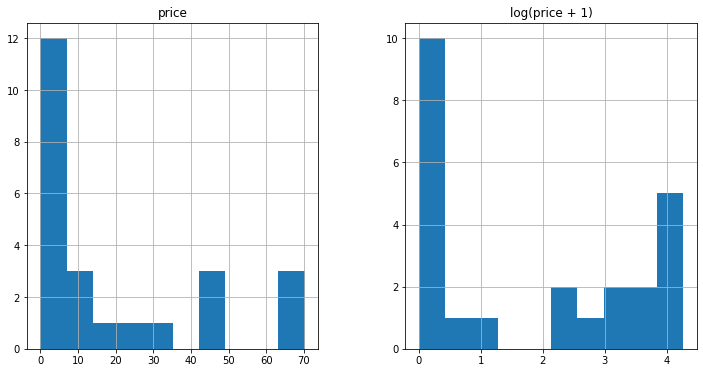

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":live2['열매수(개)'], "log(price + 1)":np.log1p(live2['열매수(개)'])})
prices.hist()

In [ ]:
corr_df = live2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr']) # s==1 은 자기자신이기 때문에 제외
df.style.background_gradient(cmap='viridis')

,,corr
엽폭(cm),엽장(cm),0.970000
엽장(cm),엽폭(cm),0.970000
착과군(점),열매수(개),0.920000
열매수(개),착과군(점),0.920000
줄기굵기(mm),엽장(cm),0.870000
엽장(cm),줄기굵기(mm),0.870000
착과군(점),최종화방번호(번),0.860000
최종화방번호(번),착과군(점),0.860000
주차,착과군(점),0.830000
착과군(점),주차,0.830000


## 3-2. env

In [ ]:
print(env2.corr())

              내부CO2(ppm)   내부습도(%)      강우감지  일사량(W/m-2·s)   외부온도(도)  \
내부CO2(ppm)      1.000000 -0.190374  0.106662     -0.422267 -0.741889   
내부습도(%)        -0.190374  1.000000  0.405624     -0.304710  0.344375   
강우감지            0.106662  0.405624  1.000000     -0.510946  0.053641   
일사량(W/m-2·s)   -0.422267 -0.304710 -0.510946      1.000000  0.466237   
외부온도(도)        -0.741889  0.344375  0.053641      0.466237  1.000000   
내부온도(도)        -0.732016  0.135669 -0.137231      0.575753  0.821146   
지온(도)          -0.759758  0.151117 -0.084324      0.447783  0.907718   
외부풍속(m/s)      -0.104698  0.054309  0.093670     -0.064576  0.001221   

               내부온도(도)     지온(도)  외부풍속(m/s)  
내부CO2(ppm)   -0.732016 -0.759758  -0.104698  
내부습도(%)       0.135669  0.151117   0.054309  
강우감지         -0.137231 -0.084324   0.093670  
일사량(W/m-2·s)  0.575753  0.447783  -0.064576  
외부온도(도)       0.821146  0.907718   0.001221  
내부온도(도)       1.000000  0.944606  -0.158054  
지온(도)         0.944606  1.000

In [ ]:
corr_df = env2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

,,corr
내부온도(도),지온(도),0.940000
지온(도),내부온도(도),0.940000
외부온도(도),지온(도),0.910000
지온(도),외부온도(도),0.910000
내부온도(도),외부온도(도),0.820000
외부온도(도),내부온도(도),0.820000
내부온도(도),일사량(W/m-2·s),0.580000
일사량(W/m-2·s),내부온도(도),0.580000
외부온도(도),일사량(W/m-2·s),0.470000
일사량(W/m-2·s),외부온도(도),0.470000


## 3-3. ctrl

In [ ]:
print(ctrl2.corr())

             좌측일중천창 작동여부  우측일중천창 작동여부  좌측이중천창 작동여부  우측이중천창 작동여부  좌측일중측창 작동여부  \
좌측일중천창 작동여부     1.000000     0.924604     0.858802     0.841724     0.895373   
우측일중천창 작동여부     0.924604     1.000000     0.789814     0.907732     0.870756   
좌측이중천창 작동여부     0.858802     0.789814     1.000000     0.852091     0.818982   
우측이중천창 작동여부     0.841724     0.907732     0.852091     1.000000     0.833715   
좌측일중측창 작동여부     0.895373     0.870756     0.818982     0.833715     1.000000   
차광커튼작동상태        0.737078     0.739025     0.553559     0.588440     0.672576   

             차광커튼작동상태  
좌측일중천창 작동여부  0.737078  
우측일중천창 작동여부  0.739025  
좌측이중천창 작동여부  0.553559  
우측이중천창 작동여부  0.588440  
좌측일중측창 작동여부  0.672576  
차광커튼작동상태     1.000000  


In [ ]:
corr_df = ctrl2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

# Modeling

## live -env

In [ ]:
live2_idx = live2.index.to_list()
env2_idx = env2.index.to_list()
type(live2_idx)

list

In [ ]:
week_idx = []
for idx in live2_idx:
  if idx in env2_idx:
    week_idx.append(idx)

In [ ]:
week_env2 = env2.loc[week_idx]
week_ctrl2 = ctrl2.loc[week_idx]
week_live2 = live2.loc[week_idx]
week_del_live2 = new_live2.loc[week_idx]

In [ ]:
live2.to_csv(path + "week_live2.csv")
new_live2.to_csv(path + "week_del_live2.csv")
env2.to_csv(path + "week_env2.csv")
ctrl2.to_csv(path + "week_ctrl2.csv")

In [ ]:
week_env2

,내부CO2(ppm),내부습도(%),강우감지,일사량(W/m-2·s),외부온도(도),내부온도(도),지온(도),외부풍속(m/s)
Date,,,,,,,,
2021-01-20,516.45,79.69,0.00,103.48,-1.99,14.60,NaN,0.24
2021-01-27,523.12,73.25,0.00,87.20,2.67,17.21,NaN,1.55
2021-02-03,504.07,67.51,0.00,168.93,-1.19,17.16,NaN,0.43
2021-02-09,486.04,66.10,0.00,147.18,-1.93,16.99,NaN,0.23
2021-02-17,437.56,69.83,0.02,137.37,-5.38,16.73,NaN,1.89
2021-02-24,507.64,72.86,0.00,143.99,1.71,16.39,15.42,0.55
2021-03-03,492.53,75.84,0.00,155.94,3.24,16.20,16.04,0.25
2021-03-10,530.17,87.89,0.00,206.93,7.19,18.55,16.78,0.57
2021-03-17,519.50,69.63,0.00,257.53,6.49,17.65,16.82,0.56


In [ ]:
week_live2

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,,
2021-01-20,2.0,0.0,0.0,2.28,66.3,38.8,5.00,0.00,0.00,0.00,0.00
2021-01-27,3.0,65.0,0.0,3.02,101.3,60.0,8.50,0.00,0.00,0.00,0.00
2021-02-03,4.0,35.0,0.0,2.52,146.3,82.5,8.50,0.00,0.00,0.00,0.00
2021-02-09,5.0,47.5,0.0,2.39,146.3,96.3,11.25,0.00,0.00,0.00,0.00
2021-02-17,6.0,67.5,0.0,3.44,165.0,115.0,12.50,0.00,0.00,0.00,0.00
2021-02-24,7.0,62.3,0.0,6.01,242.5,156.3,14.00,0.00,0.00,0.00,0.00
2021-03-03,8.0,32.5,0.0,4.72,212.5,132.5,11.75,0.00,0.00,0.00,0.00
2021-03-10,9.0,61.0,42.5,6.35,265.0,155.0,14.75,0.20,0.00,0.00,1.25
2021-03-17,10.0,62.5,115.0,7.69,323.8,259.8,17.00,0.83,0.00,0.00,3.50


In [ ]:
chulive= pd.read_excel("/content/gdrive/MyDrive/tomato/2020_0010057_01/방울토마토_생육정보_일별.xlsx")
chulive = chulive.rename(columns = chulive.iloc[0])
chulive = chulive.drop(chulive.index[0])
chulive = chulive.drop("조사일", axis = 1)

In [ ]:
chulive

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
1,14,0.0,285.0,9.36,392.5,305.0,12.0,0.9,1.35,32.25,4.5
2,15,130.0,210.0,8.38,430.0,332.5,9.25,0.63,2.53,20.5,5.25
3,16,145.0,265.0,8.71,412.5,327.5,9.75,1.13,4.8,43.5,6.5
4,17,132.5,216.3,8.72,399.0,347.5,9.5,3.7,7.85,47.75,9.5
5,18,180.0,246.3,9.13,345.0,185.0,11.25,3.6,8.98,54.5,10.75
6,19,115.0,197.5,9.45,367.5,271.3,14.5,3.65,9.5,61.5,10.5
7,20,95.0,115.0,7.25,311.3,182.5,18.5,1.13,7.5,87.0,9.0
8,21,102.5,122.5,8.28,265.0,171.3,22.75,3.7,8.88,71.75,12.0
9,22,0.0,165.0,7.6,377.5,213.3,23.0,3.55,9.53,81.5,12.5
10,23,0.0,87.5,9.11,410.8,285.0,18.0,3.6,8.7,58.5,10.5


In [ ]:
chulive.corr()

""


In [ ]:
chul= pd.read_excel("/content/gdrive/MyDrive/tomato/2020_0010057_01/방울토마토_출하량정보_일별.xlsx")

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
chul

,출하량정보_일별(방울토마토),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,조사일,총 출하량(kg),특상 등급(kg),상 등급(kg),중 등급(kg),하 등급(kg),특상 단가(원/kg),상 단가(원/kg),중 단가(원/kg),하 단가(원/kg),수입금(원),비품과율(%),출하처,비고
1,2021-01-27,852,0,0,0,0,0,0,0,0,2982000,0,아침마당,NaN
2,2021-02-03,1080,0,0,0,0,0,0,0,0,3780000,0,아침마당,NaN
3,2021-02-09,1000,0,0,0,0,0,0,0,0,3500000,0,아침마당,NaN
4,2021-02-24,2000,0,0,0,0,0,0,0,0,7000000,0,아침마당,NaN
5,2021-03-03,1200,0,0,0,0,0,0,0,0,4200000,0,아침마당,NaN
6,2021-03-10,1000,0,0,0,0,0,0,0,0,3500000,0,아침마당,NaN
7,2021-03-17,1000,0,0,0,0,0,0,0,0,3500000,0,아침마당,NaN
8,2021-03-24,1000,0,0,0,0,0,0,0,0,3500000,0,아침마당,NaN
9,2021-03-31,1000,0,0,0,0,0,0,0,0,3500000,0,아침마당,NaN


In [ ]:
chul1= pd.read_excel("/content/gdrive/MyDrive/tomato/2021_0010071_01/방울토마토_출하량정보_일별.xlsx")
chul1

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,출하량정보_일별(방울토마토),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,조사일,총 출하량(kg),특상 등급(kg),상 등급(kg),중 등급(kg),하 등급(kg),특상 단가(원/kg),상 단가(원/kg),중 단가(원/kg),하 단가(원/kg),수입금(원),비품과율(%),출하처,비고
1,2021-05-06,1263,0,0,0,0,0,0,0,0,5557200,0,세도농협,NaN
2,2021-05-12,978,0,0,0,0,0,0,0,0,4303200,0,세도농협,NaN
3,2021-05-20,957,0,0,0,0,0,0,0,0,4210800,0,세도농협,NaN
4,2021-05-26,1867,0,0,0,0,0,0,0,0,10081800,0,세도농협,NaN
5,2021-06-02,906,0,0,0,0,0,0,0,0,4892400,0,세도농협,NaN


In [ ]:
chul2= pd.read_excel("/content/gdrive/MyDrive/tomato/2021_0010076_01/방울토마토_출하량정보_일별.xlsx")
chul2

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,출하량정보_일별(방울토마토),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,조사일,총 출하량(kg),특상 등급(kg),상 등급(kg),중 등급(kg),하 등급(kg),특상 단가(원/kg),상 단가(원/kg),중 단가(원/kg),하 단가(원/kg),수입금(원),비품과율(%),출하처,비고
1,2021-05-12,1000,0,0,0,0,0,0,0,0,3500000,0,NaN,NaN
2,2021-05-17,2200,0,0,0,0,0,0,0,0,7040000,0,숲정이,NaN
3,2021-05-25,2600,0,0,0,0,0,0,0,0,9100000,0,숲정이,NaN
4,2021-06-24,900,900,0,0,0,3300,0,0,0,2970000,0,NaN,NaN


In [ ]:
chul2= pd.read_excel("/content/gdrive/MyDrive/tomato/2021_0010076_01/방울토마토_출하량정보_일별.xlsx")
chul2

In [ ]:
dic = {}
for i in range(1,16):
  globals()["eff_ctrl"+str(i)] = effcolm(globals()["ctrl"+str(i)])
  # print(globals()["eff_ctrl"+str(i)])
  

In [ ]:
class CustomDataset:

  def __init__(self, file, path =path):
    self.path = path
    self.file = file

    live = pd.read_excel(self.path + self.file+ "/방울토마토_생육정보_일별.xlsx")
    ctrl = pd.read_excel(self.path + self.file+ "/방울토마토_제어정보_일별.xlsx")
    env = pd.read_excel(self.path + self.file+ "/방울토마토_환경정보_일별.xlsx")

  def pre_pro(self):

    self.live = self.live.rename(columns=self.live.iloc[0])
    self.live = self.live.drop(live.index[0])
    live = self.live
    
    return live


In [ ]:
# 임의의 live 데이터 프레임 가져오기
live4 

,조사일,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
1,2022-01-03,3,0.0,48.75,3.68,134.0,133.25,7.25,0.15,0.0,0.0,1.0
2,2022-01-10,4,93.25,142.0,5.38,187.5,195.5,7.0,0.3,0.1,0.5,1.0
3,2022-01-17,5,169.5,301.25,5.65,237.5,259.0,6.5,0.5,0.1,1.5,1.0
4,2022-01-24,6,185.0,216.0,8.03,312.0,354.75,5.0,1.15,0.35,3.5,2.0
5,2022-01-31,7,156.0,170.0,6.93,364.75,353.75,6.5,2.05,1.05,7.75,2.75
6,2022-02-07,8,157.75,250.25,8.98,423.25,492.25,7.0,2.45,1.48,13.5,3.0
7,2022-02-14,9,169.0,140.25,7.9,385.5,310.25,6.0,3.13,2.25,19.75,4.0
8,2022-02-21,10,161.25,267.75,9.58,434.25,456.25,6.0,3.28,2.28,25.5,4.0
9,2022-02-28,11,190.5,154.75,6.9,363.5,302.5,8.5,4.15,3.15,34.25,5.0
10,2022-03-07,12,198.0,98.5,5.08,267.0,215.5,7.5,5.1,4.1,43.0,6.0


In [ ]:
ran_df = live4.iloc[:,1:-1] 
ran_df

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개)
1,3,0.0,48.75,3.68,134.0,133.25,7.25,0.15,0.0,0.0
2,4,93.25,142.0,5.38,187.5,195.5,7.0,0.3,0.1,0.5
3,5,169.5,301.25,5.65,237.5,259.0,6.5,0.5,0.1,1.5
4,6,185.0,216.0,8.03,312.0,354.75,5.0,1.15,0.35,3.5
5,7,156.0,170.0,6.93,364.75,353.75,6.5,2.05,1.05,7.75
6,8,157.75,250.25,8.98,423.25,492.25,7.0,2.45,1.48,13.5
7,9,169.0,140.25,7.9,385.5,310.25,6.0,3.13,2.25,19.75
8,10,161.25,267.75,9.58,434.25,456.25,6.0,3.28,2.28,25.5
9,11,190.5,154.75,6.9,363.5,302.5,8.5,4.15,3.15,34.25
10,12,198.0,98.5,5.08,267.0,215.5,7.5,5.1,4.1,43.0


In [ ]:
ran_df.corr()["열매수(개)"]

KeyError: ignored

## ctrl - env